### Notebook 5: Cluster Profiling

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load clustered data
df_final = pd.read_csv("outputs/clustering_results_k4.csv")

# List of categorical columns to profile
categorical_cols = [
    'Seasonality_Segment', 'EA_Segment', 'Revenue_Bucket', 'Profit_Bucket',
    'Market_Share_Segment', 'Casino_Potential_Class',
    'Churn_Segment', 'Competitiveness_Flag', 'Volume_Segment', 'Density_Segment', 'Propensity'
]

# Check number of records in each cluster
cluster_counts = df_final['Cluster'].value_counts().sort_index()
print("Cluster sizes:\n", cluster_counts)


Cluster sizes:
 Cluster
0    1947
1     737
2     308
3      38
Name: count, dtype: int64


In [2]:
for col in categorical_cols:
    print(f"\n===== {col} distribution per Cluster =====\n")
    print(df_final.groupby('Cluster')[col].value_counts(normalize=True).rename('Percentage').mul(100).round(1))



===== Seasonality_Segment distribution per Cluster =====

Cluster  Seasonality_Segment
0        1                      98.0
         3                       1.4
         0                       0.3
         2                       0.3
1        3                      54.0
         1                      18.6
         0                      16.0
         2                      11.4
2        1                      81.2
         3                       8.4
         0                       5.5
         2                       4.9
3        1                      81.6
         3                       7.9
         0                       5.3
         2                       5.3
Name: Percentage, dtype: float64

===== EA_Segment distribution per Cluster =====

Cluster  EA_Segment
0        2             98.3
         0              0.7
         1              0.6
         3              0.5
1        2             45.7
         0             33.2
         1             11.4
         3           

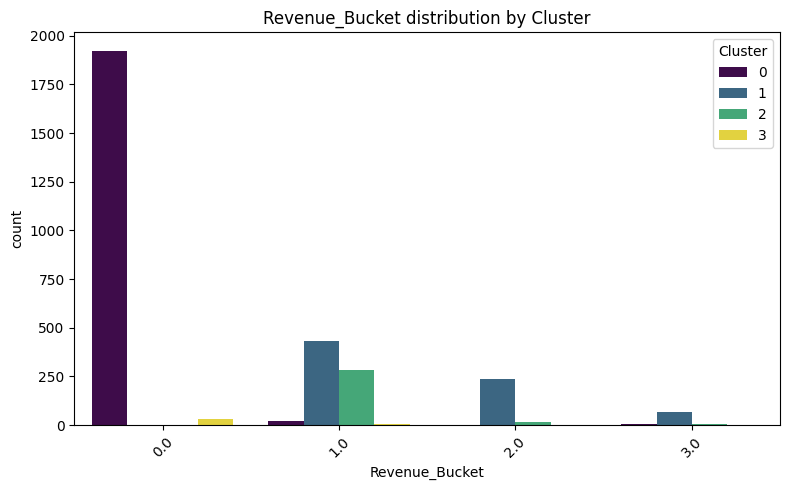

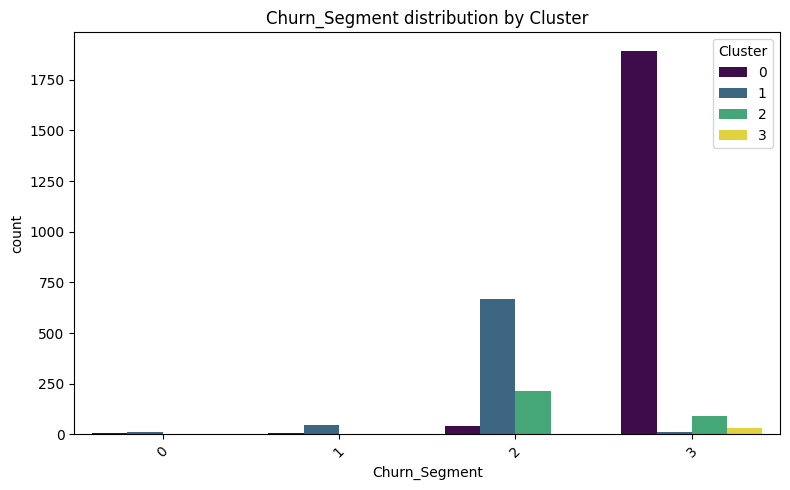

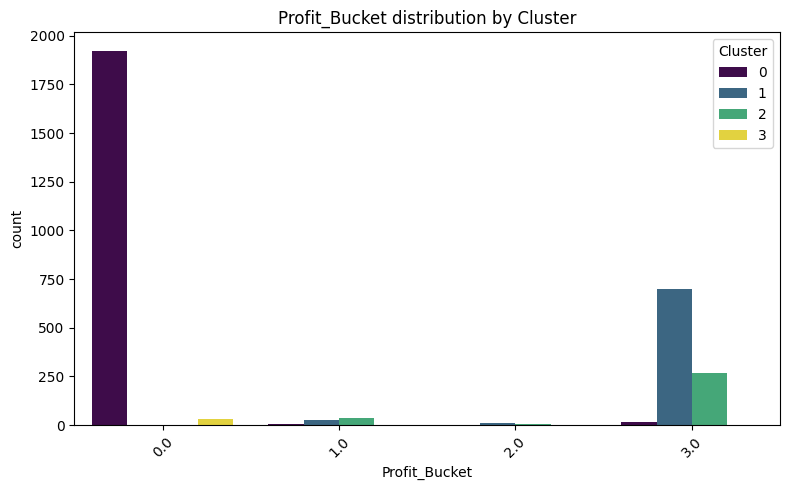

In [3]:
for col in ['Revenue_Bucket', 'Churn_Segment', 'Profit_Bucket']:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df_final, x=col, hue='Cluster', palette='viridis')
    plt.title(f"{col} distribution by Cluster")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [4]:
summary = {}

for col in categorical_cols:
    mode_per_cluster = df_final.groupby('Cluster')[col].agg(lambda x: x.value_counts().idxmax())
    summary[col] = mode_per_cluster

cluster_profile_df = pd.DataFrame(summary)
cluster_profile_df.index.name = 'Cluster'
cluster_profile_df.reset_index(inplace=True)

# Show the cluster profile summary
cluster_profile_df


,Cluster,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Potential_Class,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,0,1,2,0.0,0.0,0.0,0.0,3,0,3.0,3.0,0.0
1,1,3,2,1.0,3.0,2.0,2.0,2,1,3.0,3.0,2.0
2,2,1,2,1.0,3.0,0.0,0.0,2,1,3.0,3.0,0.0
3,3,1,2,0.0,0.0,1.0,2.0,3,1,1.0,0.0,1.0


In [ ]:
import pandas as pd
import importlib

def calculate_cluster_summary(df, categorical_cols, k_modes_model=None):
    """
    Calculates and summarizes key characteristics for each cluster, handling
    categorical data appropriately.  Optionally includes cluster centroids.

    Args:
        df (pd.DataFrame):  The DataFrame containing customer data, including the 'Cluster' column.
        categorical_cols (list): A list of the names of the categorical columns in df
            that are relevant to the clustering.
        
    Returns:
        pd.DataFrame: A DataFrame summarizing the clusters, with columns
            like 'Size' and descriptive statistics for each categorical feature.
    """

    cluster_summary = df.groupby('Cluster').agg(
        Size=('Customer_ID', 'count')  # Always include cluster size
    )

    #  Calculate percentage of each category within each cluster for categorical columns
    for col in categorical_cols:
        #  Create a separate function to handle the calculation for a single column
        def calculate_category_percentage(series, category):
            return (series == category).mean() * 100

        # Get all unique values from the column
        unique_categories = df[col].unique()
        for category in unique_categories:
            # Create meaningful column names
            new_col_name = f"{col}_{category}_%"
            cluster_summary[new_col_name] = df.groupby('Cluster')[col].agg(
                calculate_category_percentage, category=category
            )

    cluster_summary = cluster_summary.round(1)  # Round percentages for readability

    if k_modes_model:
        # Get cluster centroids (most frequent values)
        centroids_df = pd.DataFrame(k_modes_model.cluster_centroids_,
                                    columns=categorical_cols)
        # Map the centroids back to the original categorical values
        for col in categorical_cols:
            if hasattr(k_modes_model, 'category_mapping') and col in k_modes_model.category_mapping:
                category_mapping = k_modes_model.category_mapping[col]
                centroids_df[col] = centroids_df[col].map(category_mapping)

        # Add Centroids to the summary.  Use a prefix to distinguish.
        for col in categorical_cols:
            cluster_summary[f'Centroid_{col}'] = centroids_df[col]

    return cluster_summary



categorical_cols = [
    'Seasonality_Segment', 'EA_Segment', 'Revenue_Bucket', 'Profit_Bucket',
    'Market_Share_Segment', 'Casino_Potential_Class',
    'Churn_Segment', 'Competitiveness_Flag', 'Volume_Segment', 'Density_Segment',
    'Propensity', 'Casino_Potential_Class'
] 

# 3.  Get the cluster summary
cluster_summary_df = calculate_cluster_summary(df_final, categorical_cols)

# 4.  Print and save
print(cluster_summary_df)

# Check if openpyxl is installed before attempting to save to Excel.
if importlib.util.find_spec("openpyxl") is not None:
    cluster_summary_df.to_excel("outputs/VentureCreed_Cluster_Summary.xlsx")
    print("Successfully saved to VentureCreed_Cluster_Summary.xlsx")
else:
    print(
        "install the 'openpyxl' library and run this script again"
    )

         Size  Seasonality_Segment_1_%  Seasonality_Segment_0_%  \
Cluster                                                           
0        1947                     98.0                      0.3   
1         737                     18.6                     16.0   
2         308                     81.2                      5.5   
3          38                     81.6                      5.3   

         Seasonality_Segment_3_%  Seasonality_Segment_2_%  EA_Segment_2_%  \
Cluster                                                                     
0                            1.4                      0.3            98.3   
1                           54.0                     11.4            45.7   
2                            8.4                      4.9            85.1   
3                            7.9                      5.3            84.2   

         EA_Segment_0_%  EA_Segment_1_%  EA_Segment_3_%  Revenue_Bucket_0.0_%  \
Cluster                                              

### Final Cluster Profiling (with names)

| Cluster | Name                                          | Size | Key Traits                                                                                 |
| :------ | :-------------------------------------------- | :--- | :----------------------------------------------------------------------------------------- |
| **0**   | **Low-Value, High-Risk, Seasonal Accounts**      | 1947 | High churn, low revenue, low profit, low market share, low propensity                       |
| **1**   | **Stable, High-Profit, Competitive Accounts**    | 737  | High profit, moderate revenue, moderate to high propensity, competitive                     |
| **2**   | **High-Profit, Low-Potential, Competitive Accounts** | 308  | High profit, moderate revenue, low potential, competitive, high churn risk                  |
| **3**   | **Mid-Market, Low-Value, High-Risk Accounts**    | 38  | Low revenue, low profit, moderate market share, moderate potential, high churn              |
